## Import Libraries

In [ ]:
#Import the libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from itertools import groupby
import os, os.path
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import davies_bouldin_score
from scipy.special import kl_div

## Loading the Dataset

In [2]:
filename = 'User_011_latlontime.csv'
df = pd.read_csv(filename, encoding='utf-8')
df = df.iloc[: , 1:]
# represent points consistently as (Latitude, Longitude)
coords = df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df['Time'].values.tolist()

In [3]:
print('Total points: ',len(coords))

Total points:  90602


In [4]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

## Data Preprocessing

In [5]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled_data=model.transform(df)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

In [6]:
# Setting value of epsilon for clustering
epsilon = 0.1

## Implementing EDDBSCAN

In [7]:
# To find minPoints using merge-sort algorithm
l=1
r=len(coords)
v=[]
w=[]
def divide(l, r):
    if l<r:
        m = l+(r-l)//2
        try:
            sil_score, num_clusters = cal(m, epsilon)
            if sil_score not in v and num_clusters>0:
                v.append(sil_score)
                w.append(m)
                divide(l, m)
        except ValueError:
            divide(l, m)
    else:
        return
def cal(m,epsilon):
    db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
    sil_score = metrics.silhouette_score(normalized_data, db.labels_)
    num_clusters = len(set(db.labels_)) #- (1 if -1 in db.labels_ else 0)
    return [sil_score, num_clusters]
divide(l,r)
max_i = max(v)
max_i_index = v.index(max_i)
min_point = w[max_i_index]

In [8]:
db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

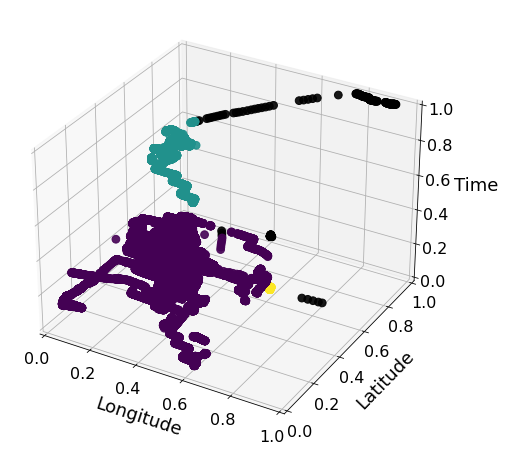

In [9]:
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
#plt.gca().add_artist(first_legend)
#plt.legend(loc='upper left')
plt.show()

In [10]:
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(normalized_data, cluster_labels)))

Silhouette coefficient: 0.815


In [11]:
print(num_clusters)

4


In [12]:
print('Davies-Bouldin score: {:0.03f}'.format(davies_bouldin_score(normalized_data, cluster_labels)))

Davies-Bouldin score: 0.319


### Calculation of KL divergence after each recorded GPS point

### Mapping of points in a 3D space-time grid and calculate distance using KL-divergence after addition of each new point

In [13]:
#Initialize values to partition along number of grids n each axis
x=10
y=10
z=24

In [14]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),x)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), y)
Z = np.linspace(0,z,z)

grids_index = np.zeros((x,y,z))
point_count_inside_grid = np.zeros((1,x*y*z))
flat_hist = np.ones((1,x*y*z))
d=1
kl_pq = np.zeros((1,len(coords)))

for t in range(z):
    for yax in range(y):
        for xax in range(x):
            grids_index[xax,yax,t]=d
            d=d+1

for counter in range(len(coords)):
    p_lat = lats_xy[counter]
    p_long = longs_xy[counter]
    p_time = user_time[counter]
    for t in range(z):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(y):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(x):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            normalizedData = (point_count_inside_grid-np.min(point_count_inside_grid))/(np.max(point_count_inside_grid)-np.min(point_count_inside_grid))
                            #distance = sum(rel_entr(normalizedData, flat_hist)[0,:])
                            distance = sum(kl_div(normalizedData[0,:], flat_hist[0,:]))
                            #kl_pq[:,counter] = abs(distance)
                            kl_pq[:,counter] = distance

### Find points that can be transmitted directly

In [15]:
threshold = 0.08
delta_2 = 0/100

In [16]:
max_limit = (threshold/100)*len(coords) 
new_data = []
scaled_points = []
for temp in range(kl_pq.size-1):
    if kl_pq[:,temp] != 0:
        percent_change = ((kl_pq[:,temp+1]-kl_pq[:,temp])/kl_pq[:,temp])*100
        if percent_change < 0:
            new_data.append(df.iloc[temp].tolist())
            scaled_points.append(scaled_data[temp].tolist())

In [17]:
print('Transmitted points: ',len(scaled_points))

Transmitted points:  82059


In [18]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(scaled_points, columns = ['Latitude','Longitude','Time'])

In [19]:
coords = new_df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = new_df['Time'].values.tolist()
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
d=1
new_points = []
new_scaled_points = []

In [20]:
# Store maximum of max_limit % points in a grid
for counter in range(len(coords)):
    p_lat = lats_xy[counter]
    p_long = longs_xy[counter]
    p_time = user_time[counter]
    for t in range(z):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(y):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(x):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            if point_count_inside_grid[:,int(found_at)] <= max_limit:
                                new_points.append(new_df.iloc[counter].tolist())
                                new_scaled_points.append(normalized_data.iloc[counter].tolist())

In [21]:
new_df = pd.DataFrame(new_points, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(new_scaled_points, columns = ['Latitude','Longitude','Time'])

### Plot directly transmitted normalized data points

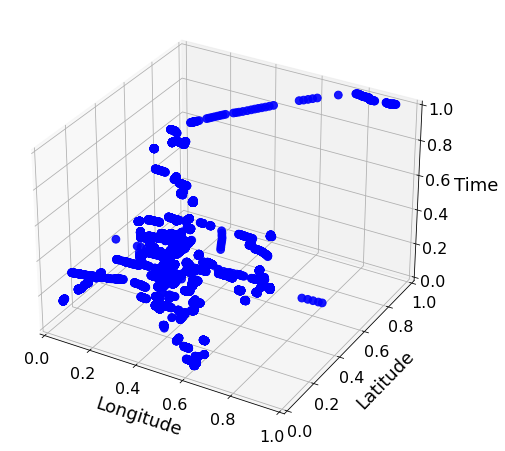

In [22]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
plt.show()

### Clustering of directly transmitted data points

In [23]:

# To find minPoints using merge-sort algorithm
l=1
r=len(normalized_data)
v=[]
w=[]
def divide(l, r):
    if l<r:
        m = l+(r-l)//2
        try:
            sil_score, num_clusters = cal(m, epsilon)
            if sil_score not in v and num_clusters>0:
                v.append(sil_score)
                w.append(m)
                divide(l, m)
        except ValueError:
            divide(l, m)
    else:
        return
def cal(m,epsilon):
    db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
    num_clusters = len(set(db.labels_)) #- (1 if -1 in db.labels_ else 0)
    sil_score = metrics.silhouette_score(normalized_data, db.labels_)
    return [sil_score, num_clusters]
divide(l,r)
max_i = max(v)
max_i_index = v.index(max_i)
min_point = w[max_i_index]

In [24]:
#db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

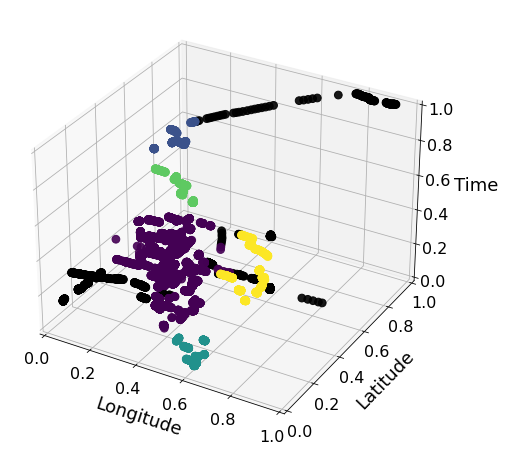

In [25]:
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(loc='upper left')
#plt.gca().add_artist(first_legend)
#plt.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=5, frameon=True)
plt.show()

In [26]:
print(num_clusters)

6


In [27]:
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(normalized_data, cluster_labels)))

Silhouette coefficient: 0.753


In [28]:
print(davies_bouldin_score(normalized_data, cluster_labels))

0.32641446025698956
